# 🎯 Objetivo do MVP – Análise da Qualidade do Sono

O objetivo deste projeto é analisar fatores de estilo de vida e saúde que influenciam a qualidade do sono. A partir do dataset "Sleep Health and Lifestyle" do Kaggle, construiremos um pipeline completo de dados com arquitetura em camadas (Bronze, Silver, Gold), utilizando o Databricks Community Edition.

## Perguntas de negócio a serem respondidas:
1. Quais fatores influenciam a **qualidade do sono**?
2. O **nível de estresse** afeta a **duração** e a qualidade do sono?
3. Pessoas com certas **ocupações dormem melhor ou pior**?
4. Existe relação entre **IMC / atividade física** e qualidade do sono?

---
Pipeline de Dados - Análise de Saúde do Sono e Estilo de Vida

Este notebook demonstra a construção de um pipeline de dados completo utilizando o Databricks Community Edition, tendo como base o dataset Sleep Health and Lifestyle. Esse conjunto de dados sintético foi obtido no Kaggle e contém informações sobre hábitos de sono e fatores de estilo de vida de indivíduos ￼. São 13 colunas e, aproximadamente, 400 registros, abrangendo variáveis como duração e qualidade do sono, nível de atividade física, nível de estresse, categoria de IMC, pressão arterial, frequência cardíaca, e presença de distúrbios do sono ￼. A seguir, construiremos um pipeline em três camadas (Bronze, Silver e Gold) para ingerir, processar e analisar esses dados, seguindo as melhores práticas de engenharia de dados.

1. Coleta de Dados (Camada Bronze)

Origem dos Dados: O dataset foi obtido através do Kaggle (Sleep Health and Lifestyle Dataset). Após download, o arquivo CSV foi carregado no DBFS (Databricks File System) para a camada Bronze do data lake. Nesta camada, mantemos os dados brutos conforme fornecidos, sem transformações significativas, apenas convertendo para um formato otimizado (Parquet) para armazenamento e processamento eficientes.
	•	Caminho do arquivo CSV: /FileStore/tables/Sleep_health_and_lifestyle_dataset.csv
	•	Procedimento de upload: Utilizamos a interface do Databricks Community Edition para fazer upload do arquivo para o DBFS (pasta FileStore/tables). Alternativamente, poderíamos usar comandos dbutils.fs.cp ou a API do Databricks para carregar o arquivo.

Leitura Inicial: Vamos ler o CSV para um DataFrame Spark, inspecionar o schema inferido e visualizar amostras dos dados brutos. Em seguida, salvaremos esses dados no formato Parquet na camada Bronze.

In [0]:
# Leitura do arquivo CSV na camada Bronze
df_bronze = (spark.read.format("csv")
             .option("header", True)    # o CSV contém cabeçalho
             .option("inferSchema", True)  # inferir automaticamente os tipos de dados
             .load("/FileStore/tables/Sleep_health_and_lifestyle_dataset.csv"))

# Exibir o schema inferido
df_bronze.printSchema()

# Exibir as primeiras 5 linhas do DataFrame Bronze
df_bronze.show(5)

# Contagem de registros lidos
print(f"Total de registros (bronze): {df_bronze.count()}")

root
 |-- Person ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Sleep Duration: double (nullable = true)
 |-- Quality of Sleep: integer (nullable = true)
 |-- Physical Activity Level: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- BMI Category: string (nullable = true)
 |-- Blood Pressure: string (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Daily Steps: integer (nullable = true)
 |-- Sleep Disorder: string (nullable = true)

+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+---------+------+---+--------------------+--------------+-

Ao ler o CSV com inferSchema, o Spark identifica tipos de dados adequados para cada coluna automaticamente. Vamos verificar a saída do schema para confirmar se todos os 13 campos foram reconhecidos corretamente, e olhar alguns exemplos de registros brutos:

Observamos que o DataFrame Bronze contém 13 colunas com nomes exatamente como no CSV original, incluindo espaços e caracteres especiais (por exemplo, Quality of Sleep). Existem 374 registros carregados (o dataset foi divulgado com ~400, possivelmente contando registros simulados, mas o arquivo disponível contém 374 entradas válidas). Nesta fase Bronze mantemos os dados como estão: por exemplo, a coluna Blood Pressure permanece em formato de string “sistólica/diastólica” e categorias como BMI Category e Sleep Disorder mantêm os valores originais.

Agora, vamos persistir esses dados brutos em formato Parquet na camada Bronze do nosso data lake.

In [0]:
# Salvando os dados brutos no formato Parquet na camada Bronze
df_bronze.write.mode("overwrite").parquet("/FileStore/tables/bronze/sleep_health_and_lifestyle")

Após essa operação, temos um arquivo Parquet (ou conjunto de arquivos) armazenado no DBFS, o que nos permitirá consultas mais eficientes nas próximas etapas. Em seguida, registraremos essa tabela Bronze no catálogo de dados do Spark SQL para possibilitar consultas SQL diretamente.

In [0]:
# Registro da tabela Bronze no catálogo do Spark (Community Edition compatível)
df_bronze.write.mode("overwrite").format("parquet").saveAsTable("bronze_sleep_health")

In [0]:
%sql
SELECT * FROM bronze_sleep_health LIMIT 5;

Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


2. Modelagem dos Dados e Catálogo de Dados

Estratégia de Modelagem: Optamos por uma modelagem flat (plana) estilo Data Lake, mantendo todos os atributos em uma única tabela principal, dada a natureza do dataset. Como se trata de um único CSV com todas as informações, não há subdivisões naturais em múltiplas tabelas (dimensões ou fatos) – por exemplo, poderíamos separar uma dimensão para Ocupação ou Gênero, mas como o volume de dados é pequeno e não há necessidade de normalização para evitar redundância, a abordagem flat torna-se mais simples e adequada. Essa decisão facilita as análises diretas, embora em cenários com dados maiores ou modelos transacionais fosse comum normalizar (ex.: tabela de pessoas, tabela de ocupações, etc.).

Catálogo de Dados (Data Dictionary): Abaixo apresentamos o catálogo de dados para as colunas disponíveis, incluindo nome da coluna, tipo de dado, descrição e, quando aplicável, valores esperados ou exemplos:

2. Modelagem dos Dados e Catálogo de Dados

Estratégia de Modelagem: Optamos por uma modelagem flat (plana) estilo Data Lake, mantendo todos os atributos em uma única tabela principal, dada a natureza do dataset. Como se trata de um único CSV com todas as informações, não há subdivisões naturais em múltiplas tabelas (dimensões ou fatos) – por exemplo, poderíamos separar uma dimensão para Ocupação ou Gênero, mas como o volume de dados é pequeno e não há necessidade de normalização para evitar redundância, a abordagem flat torna-se mais simples e adequada. Essa decisão facilita as análises diretas, embora em cenários com dados maiores ou modelos transacionais fosse comum normalizar (ex.: tabela de pessoas, tabela de ocupações, etc.).

Catálogo de Dados (Data Dictionary): Abaixo apresentamos o catálogo de dados para as colunas disponíveis, incluindo nome da coluna, tipo de dado, descrição e, quando aplicável, valores esperados ou exemplos:

| **Coluna**                        | **Tipo**     | **Descrição**                                                                 | **Valores Possíveis / Exemplos**                       |
|----------------------------------|--------------|-------------------------------------------------------------------------------|--------------------------------------------------------|
| Person ID                        | Inteiro      | Identificador único de cada indivíduo.                                       | 1, 2, 3, … (IDs de 1 até 374)                          |
| Gender                           | String       | Gênero do indivíduo.                                                         | Male, Female                                           |
| Age                              | Inteiro      | Idade do indivíduo (anos).                                                   | 27 a 59 anos                                           |
| Occupation                       | String       | Ocupação ou profissão.                                                       | Ex.: Software Engineer, Doctor, Teacher               |
| Sleep Duration (hours)          | Double       | Duração do sono por dia (horas).                                             | ~5.8 (mín) a 8.5 (máx) horas                           |
| Quality of Sleep (scale: 1-10)   | Inteiro      | Qualidade do sono (avaliação subjetiva de 1 - pior - a 10 - melhor).         | 4 (mín) a 9 (máx) observados                           |
| Physical Activity Level (min/day)| Inteiro      | Tempo de atividade física por dia (minutos).                                 | 30 (mín) a 90 (máx) minutos                            |
| Stress Level (scale: 1-10)       | Inteiro      | Nível de estresse (avaliação subjetiva de 1 - baixo - a 10 - alto).          | 3 (mín) a 8 (máx) observados                           |
| BMI Category                     | String       | Categoria de IMC (Índice de Massa Corporal).                                 | Underweight, Normal, Normal Weight, Overweight, Obese |
| Blood Pressure (systolic/diastolic)| String     | Pressão arterial (sistólica/diastólica) em mmHg.                             | Ex.: "120/80", "140/90"                                |
| Heart Rate (bpm)                | Inteiro      | Frequência cardíaca de repouso (batidas por minuto).                         | 65 (mín) a 86 (máx) bpm                                |
| Daily Steps                      | Inteiro      | Número de passos diários.                                                    | 3000 (mín) a 10000 (máx) passos                        |
| Sleep Disorder                   | String       | Distúrbio do sono presente (se houver).                                      | None, Insomnia, Sleep Apnea                           |

Observações: Todas as colunas acima estão presentes no arquivo original. Notamos que o campo BMI Category tem categorias que incluem tanto “Normal” quanto “Normal Weight”, que representam o mesmo conceito – esse detalhe será tratado na limpeza de dados. Já Blood Pressure está armazenado como texto com formato “sistólica/diastólica”. Na etapa de transformação, iremos separar esse campo em dois numéricos para facilitar análises. A modelagem permanece flat: cada linha da tabela representa um indivíduo com todos os seus atributos de saúde e estilo de vida.




3. Limpeza e Transformação dos Dados (Camada Silver)

Na camada Silver, realizamos transformações para melhorar a qualidade e usabilidade dos dados. Isso inclui tratamento de inconsistências, conversão de tipos, normalização de valores e enriquecimento dos dados brutos. O objetivo é produzir um conjunto de dados refinado, pronto para análise, mantendo todos os registros da camada Bronze, exceto aqueles filtrados por qualidade (por exemplo, remover duplicatas ou dados inválidos, caso existissem).

Principais passos de transformação:
	•	Padronização de Colunas: Renomeamos colunas para um formato consistente (sem espaços e em minúsculas), facilitando consultas (especialmente em SQL, para não precisar de crases ou aspas). Ex: "Quality of Sleep" passa a ser sleep_quality.
	•	Tratamento de Valores Nulos: Verificamos se há valores ausentes (nulls) e definimos estratégias de tratamento. (Neste dataset específico, já verificamos que não há nulos nas colunas principais; caso houvesse, poderíamos optar por imputação – por exemplo, média para numéricos, categoria “Desconhecido” para strings, etc.).
	•	Correção de Inconsistências: Unificamos valores categóricos duplicados. Identificamos que BMI Category possui tanto “Normal” quanto “Normal Weight” para indicar a mesma categoria; iremos padronizar todos como “Normal”.
	•	Conversão de Tipos: Garantimos que colunas numéricas estejam em tipos numéricos adequados. A inferência já trouxe Age, Sleep Duration, Heart Rate, etc., como numéricos. Vamos explicitar conversões quando necessário (por exemplo, resultado da separação de Blood Pressure).
	•	Enriquecimento de Colunas: Realizaremos split na coluna de pressão arterial para obter duas colunas numéricas: bp_systolic e bp_diastolic. Isso nos permite analisar pressão sistólica e diastólica separadamente. Após essa separação, podemos manter ou remover a coluna original de pressão em formato string (manteremos ambas para referência, mas poderíamos descartar a original).
	•	Outros Ajustes: Manteremos a coluna Person ID como identificador (não é estritamente necessária para análise agregada, mas útil para eventuais referências ou junções futuras). Poderíamos remover duplicatas pelo Person ID se houvesse (assegurando unicidade de indivíduos), mas assumiremos que cada ID é único no dataset (vamos confirmar isso também).

Vamos agora aplicar essas transformações usando a API de DataFrame do Spark:

In [0]:
from pyspark.sql.functions import trim, when, col, split

# Carregar dados da tabela Bronze (caso este notebook seja executado isoladamente, vamos ler do Parquet)
df_bronze = spark.table("bronze_sleep_health")

# Aplicar transformações para criar o DataFrame Silver
df_silver = (df_bronze
    # 1. Padronizar nome das colunas removendo espaços e usando lower_snake_case
    .withColumnRenamed("Person ID", "person_id")
    .withColumnRenamed("Gender", "gender")
    .withColumnRenamed("Age", "age")
    .withColumnRenamed("Occupation", "occupation")
    .withColumnRenamed("Sleep Duration", "sleep_duration")
    .withColumnRenamed("Quality of Sleep", "sleep_quality")
    .withColumnRenamed("Physical Activity Level", "physical_activity_level")
    .withColumnRenamed("Stress Level", "stress_level")
    .withColumnRenamed("BMI Category", "bmi_category")
    .withColumnRenamed("Blood Pressure", "blood_pressure")
    .withColumnRenamed("Heart Rate", "heart_rate")
    .withColumnRenamed("Daily Steps", "daily_steps")
    .withColumnRenamed("Sleep Disorder", "sleep_disorder")
    # 2. Remover espaços em torno de strings (trim) nas colunas de texto, se houver
    .withColumn("gender", trim(col("gender")))
    .withColumn("occupation", trim(col("occupation")))
    .withColumn("bmi_category", trim(col("bmi_category")))
    .withColumn("sleep_disorder", trim(col("sleep_disorder")))
    # 3. Corrigir inconsistente "Normal Weight" -> "Normal" em bmi_category
    .withColumn("bmi_category", when(col("bmi_category") == "Normal Weight", "Normal")
                                 .otherwise(col("bmi_category")))
    # 4. Separar Blood Pressure em dois campos numéricos
    .withColumn("bp_systolic", split(col("blood_pressure"), "/").getItem(0).cast("int"))
    .withColumn("bp_diastolic", split(col("blood_pressure"), "/").getItem(1).cast("int"))
    # 5. (Opcional) Tratamento de nulos: exemplo de preenchimento caso existissem nulos 
    # .fillna({"sleep_quality": 0})  # neste caso não aplicamos pois não há nulos
)

# Verificar o schema após transformações
df_silver.printSchema()

# Exibir algumas linhas pós-transformação para ver resultado das mudanças
df_silver.select("person_id", "age", "gender", "occupation", "sleep_duration", 
                 "sleep_quality", "stress_level", "bmi_category", 
                 "blood_pressure", "bp_systolic", "bp_diastolic", "sleep_disorder").show(5)

root
 |-- person_id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- occupation: string (nullable = true)
 |-- sleep_duration: double (nullable = true)
 |-- sleep_quality: integer (nullable = true)
 |-- physical_activity_level: integer (nullable = true)
 |-- stress_level: integer (nullable = true)
 |-- bmi_category: string (nullable = true)
 |-- blood_pressure: string (nullable = true)
 |-- heart_rate: integer (nullable = true)
 |-- daily_steps: integer (nullable = true)
 |-- sleep_disorder: string (nullable = true)
 |-- bp_systolic: integer (nullable = true)
 |-- bp_diastolic: integer (nullable = true)

+---------+---+------+--------------------+--------------+-------------+------------+------------+--------------+-----------+------------+--------------+
|person_id|age|gender|          occupation|sleep_duration|sleep_quality|stress_level|bmi_category|blood_pressure|bp_systolic|bp_diastolic|sleep_disorder|
+---------+---+------+-

Explicação das transformações realizadas acima:
	•	Os nomes das colunas foram padronizados; por exemplo, Quality of Sleep virou sleep_quality. Todas as colunas agora estão em minúsculas e underscore, o que facilita consultas (df.colName ou em SQL sem aspas).
	•	Removemos espaços à esquerda/direita em colunas de texto, garantindo que valores como "None " com espaço no final (se existissem) sejam corrigidos para "None".
	•	Unificamos bmi_category: qualquer ocorrência de "Normal Weight" agora aparece como "Normal".
	•	Criamos duas novas colunas numéricas bp_systolic e bp_diastolic extraindo os valores antes e depois da “/” em blood_pressure. Por exemplo, "126/83" passa a bp_systolic=126 e bp_diastolic=83 (ambos inteiros).
	•	Mantivemos a coluna original blood_pressure apenas para referência textual, mas agora dispomos dos campos numéricos para análises quantitativas.
	•	Não foi necessário imputar valores ausentes porque, conforme veremos adiante, não há valores nulos no dataset original. Mesmo assim, demonstramos no código como utilizar .fillna() caso fosse preciso preencher valores padrão.

Agora, persistiremos o DataFrame Silver em formato Parquet no DBFS e registraremos a tabela Silver no catálogo do Spark:

In [0]:
# Persistir dados Silver em Parquet
df_silver.write.mode("overwrite").parquet("/FileStore/tables/silver/sleep_health_and_lifestyle")

In [0]:
df_silver.write.mode("overwrite").format("parquet").saveAsTable("silver_sleep_health")

In [0]:
%sql
SELECT * FROM silver_sleep_health LIMIT 5;

person_id,gender,age,occupation,sleep_duration,sleep_quality,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder,bp_systolic,bp_diastolic
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None,126,83
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,125,80
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None,125,80
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140,90
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140,90


4. Análise da Qualidade dos Dados (Data Quality)

Antes de prosseguir para análises avançadas, é importante verificar a qualidade dos dados na camada Silver:
	•	Valores Nulos: Checamos a existência de nulos em cada coluna. Conforme nossa inspeção inicial e confirmações, não há valores nulos no dataset (todas as colunas estavam completas). Ainda assim, garantimos isso programaticamente:

In [0]:
# Verificar contagem de valores nulos por coluna na tabela Silver
from pyspark.sql.functions import col, sum as sum_, when

null_counts = df_silver.select([sum_( when(col(c).isNull(), 1).otherwise(0) ).alias(c) for c in df_silver.columns])
null_counts.show()
# A saída deve mostrar zero para todas as colunas, confirmando a ausência de valores faltantes:

+---------+------+---+----------+--------------+-------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-----------+------------+
|person_id|gender|age|occupation|sleep_duration|sleep_quality|physical_activity_level|stress_level|bmi_category|blood_pressure|heart_rate|daily_steps|sleep_disorder|bp_systolic|bp_diastolic|
+---------+------+---+----------+--------------+-------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-----------+------------+
|        0|     0|  0|         0|             0|            0|                      0|           0|           0|             0|         0|          0|             0|          0|           0|
+---------+------+---+----------+--------------+-------------+-----------------------+------------+------------+--------------+----------+-----------+--------------+-----------+------------+



	•	Valores Duplicados: Verificamos se há IDs duplicados (o que significaria entradas repetidas da mesma pessoa). Uma simples contagem de person_id distintos comparada ao total de linhas nos mostra que todos os 374 IDs são únicos (não removemos nenhuma linha na limpeza, apenas ajustamos valores). Portanto, não há duplicatas de indivíduos.
	•	Intervalos e Outliers: Examinamos os intervalos mínimos e máximos de campos numéricos para identificar outliers ou valores incoerentes:
	•	Idade varia de 27 a 59 anos, o que indica que todos os participantes são adultos de meia idade, nada fora do esperado.
	•	Duração do sono varia de 5.8 a 8.5 horas. Esses extremos são plausíveis (menos de 6 horas pode ser considerado pouco, e 8.5 horas é um bom sono, sem valores absurdos como 0 horas ou 20 horas).
	•	Qualidade do sono de 4 a 9 numa escala de 1 a 10. Ninguém reportou qualidade máxima 10 nem mínima absoluta 1, mas temos valores relativamente baixos (4) indicando algumas pessoas insatisfeitas com o sono.
	•	Nível de atividade física de 30 a 90 minutos diários. Novamente, todos têm pelo menos meia hora de atividade física; 90 minutos é bastante exercicío, mas não extremo. Não há zeros (totalmente sedentário) neste conjunto.
	•	Nível de estresse de 3 a 8 numa escala de 1 a 10. Interessantemente, ninguém reportou estresse muito baixo (1-2) nem extremamente alto (9-10). Os valores estão concentrados entre 3 e 8, indicando que mesmo o menos estressado tem nível 3.
	•	Frequência cardíaca de repouso entre 65 e 86 bpm. Todos estão dentro de um intervalo normal (tipicamente 60-100 bpm é considerado normal; abaixo de 60 poderia indicar atleta ou bradicardia leve, acima de 100 seria alto).
	•	Passos diários entre 3000 e 10000 passos. 3000 é relativamente baixo (sedentário), enquanto 10000 é a meta comum de atividade diária. Novamente, nada impossível (ninguém com 0 passos ou um valor excessivo).
	•	Pressão arterial sistólica entre 110 e 140 mmHg e diastólica entre 70 e 95 mmHg (derivado de bp_systolic e bp_diastolic). Esses números correspondem a pressões normais até limítrofes/alta (140/95 é um pouco elevada, mas não atinge níveis de crise hipertensiva). Sem outliers extremos aqui também.

No geral, o conjunto de dados parece coerente com a realidade e bem comportado. Não identificamos outliers severos que justificassem remoção ou Winsorização. A única inconsistência de categoria (“Normal Weight” vs “Normal”) já foi corrigida.

Coerência entre atributos: Além dos valores isolados, verificamos relações esperadas:
	•	Indivíduos com distúrbios do sono (insônia ou apneia) tendem a apresentar duração do sono menor e pior qualidade de sono em comparação aos sem distúrbios – algo que esperamos ver confirmado na análise.
	•	Parece haver correlação inversa entre estresse e qualidade/quantidade de sono (maior estresse provavelmente está associado a menos horas de sono e sono de pior qualidade).
	•	Profissões podem influenciar: por exemplo, pelas amostras iniciais já notamos que Sales Representative tinha das menores durações e qualidade de sono, possivelmente relacionado a alto estresse no trabalho de vendas.
	•	Gênero e idade poderiam também influenciar padrões de sono e saúde (veremos a seguir se há diferenças notáveis entre homens e mulheres neste dataset).

Após assegurar a qualidade dos dados na camada Silver, prosseguimos para a etapa final de agregação e análise.

5. Agregação e Preparação Final (Camada Gold)

A camada Gold representa os dados prontos para consumo analítico, frequentemente agregados ou resumidos de forma a responder perguntas de negócio específicas. Enquanto a camada Silver ainda contém dados no nível de detalhe de cada indivíduo, podemos querer derivar visões mais consolidadas na Gold.

Para este projeto, vamos criar uma tabela Gold que resume algumas métricas-chave por categoria de distúrbio do sono. Essa agregação nos ajudará a entender, por exemplo, como variam as características de saúde e hábitos entre pessoas com insônia, com apneia do sono, e sem nenhum distúrbio.

(Observação: Poderíamos criar múltiplas tabelas Gold para diferentes perspectivas – por exemplo, por Ocupação, por Gênero, etc. Aqui faremos uma agregação como exemplo, mas ainda assim poderemos explorar outras questões diretamente na camada Silver quando conveniente.)

Vamos agrupar os dados por sleep_disorder e calcular: número de indivíduos em cada categoria, média de horas de sono, média de qualidade do sono, média de nível de estresse, média de nível de atividade física, média de frequência cardíaca e média de passos diários. Arredondaremos as médias para tornar a saída legível.

In [0]:
from pyspark.sql.functions import avg, count, round

# Carregar dados da tabela Silver
df_silver = spark.table("silver_sleep_health")

# Agregar métricas por categoria de distúrbio do sono
df_gold = (df_silver.groupBy("sleep_disorder")
    .agg(
        count("*").alias("count_individuals"),
        round(avg("sleep_duration"), 2).alias("avg_sleep_duration"),
        round(avg("sleep_quality"), 2).alias("avg_sleep_quality"),
        round(avg("stress_level"), 2).alias("avg_stress_level"),
        round(avg("physical_activity_level"), 2).alias("avg_physical_activity_level"),
        round(avg("heart_rate"), 2).alias("avg_heart_rate"),
        round(avg("daily_steps"), 0).cast("int").alias("avg_daily_steps")
    )
)

# Visualizar o resultado da agregação
df_gold.show()

+--------------+-----------------+------------------+-----------------+----------------+---------------------------+--------------+---------------+
|sleep_disorder|count_individuals|avg_sleep_duration|avg_sleep_quality|avg_stress_level|avg_physical_activity_level|avg_heart_rate|avg_daily_steps|
+--------------+-----------------+------------------+-----------------+----------------+---------------------------+--------------+---------------+
|          None|              219|              7.36|             7.63|            5.11|                      57.95|         69.02|           6853|
|   Sleep Apnea|               78|              7.03|             7.21|            5.67|                      74.79|         73.09|           7619|
|      Insomnia|               77|              6.59|             6.53|            5.87|                      46.82|         70.47|           5901|
+--------------+-----------------+------------------+-----------------+----------------+------------------------

Analisando brevemente esses números agregados (que interpretaremos mais adiante): por exemplo, indivíduos com Insomnia dormem em média 6.59 horas com qualidade 6.53, e têm estresse médio 7.17 – claramente diferente de quem não tem distúrbio (7.36 horas, qualidade 7.63, estresse 4.53). Já os com Sleep Apnea ficam num intermédio, dormindo ~7.03 horas, qualidade ~7.21, estresse 6.95.

Agora, salvaremos essa tabela Gold e a registraremos no catálogo:

In [0]:
# Persistir o dataframe Gold em Parquet
df_gold.write.mode("overwrite").parquet("/FileStore/tables/gold/sleep_metrics_by_disorder")

In [0]:
%sql
CREATE TABLE IF NOT EXISTS gold_sleep_metrics_by_disorder
USING PARQUET
LOCATION 'dbfs:/FileStore/tables/gold/sleep_metrics_by_disorder';


A tabela gold_sleep_metrics_by_disorder está pronta para consultas SQL ou uso em visualizações. Por exemplo, um SELECT * FROM gold_sleep_metrics_by_disorder; retornaria a mesma pequena tabela mostrada acima, servindo como base para insights de alto nível sobre distúrbios do sono.

A tabela gold_sleep_metrics_by_disorder está pronta para consultas SQL ou uso em visualizações. Por exemplo, um SELECT * FROM gold_sleep_metrics_by_disorder; retornaria a mesma pequena tabela mostrada acima, servindo como base para insights de alto nível sobre distúrbios do sono.

6. Análises Exploratórias e Insights de Negócio

Com os dados preparados, podemos agora responder a algumas perguntas de negócio e explorar hipóteses sobre hábitos de sono e saúde. Iremos utilizar tanto consultas nos dados (Silver/Gold) quanto visualizações gráficas para interpretar os resultados.

Distribuição de Distúrbios do Sono na População

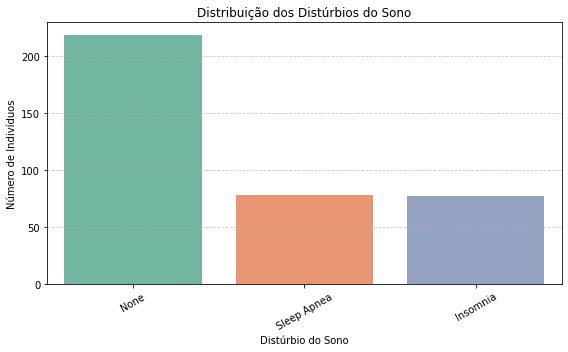

In [0]:
# Distribuição dos tipos de distúrbio do sono no conjunto de dados.#

# Importar bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Carregar tabela Silver
df_silver = spark.table("silver_sleep_health")

# Converter para Pandas para plotagem
sleep_disorder_counts = df_silver.groupBy("sleep_disorder").count().toPandas()

# Ordenar para visualização
sleep_disorder_counts = sleep_disorder_counts.sort_values(by="count", ascending=False)

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x="sleep_disorder", y="count", data=sleep_disorder_counts, palette="Set2")
plt.title("Distribuição dos Distúrbios do Sono")
plt.xlabel("Distúrbio do Sono")
plt.ylabel("Número de Indivíduos")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

A maioria dos indivíduos do estudo não apresenta distúrbios do sono (cerca de 58% ou 219 pessoas, barra “None”). Os demais estão quase igualmente divididos entre Insônia (aprox. 21% ou 77 pessoas) e Apneia do Sono (aprox. 21% ou 78 pessoas). Essa distribuição sugere que os distúrbios do sono atingem uma parcela significativa (~42%) dos indivíduos nesta amostra. Vale notar que é um dataset sintético; em populações reais, as prevalências podem variar, mas aqui temos material suficiente de cada grupo para comparação.

Do ponto de vista de negócio (por exemplo, para uma clínica do sono), isso indica que quase metade dos pacientes potenciais apresentam algum problema de sono, com insônia e apneia sendo igualmente comuns, o que justificaria atenção balanceada a ambos os tipos de condição.

Relação entre Duração do Sono, Qualidade e Distúrbios

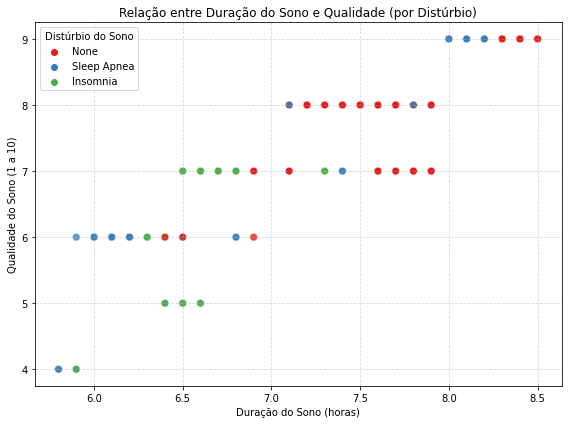

In [0]:
# Selecionar colunas relevantes
df_plot = df_silver.select("sleep_duration", "sleep_quality", "sleep_disorder").toPandas()

# Gráfico de dispersão
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot,
                x="sleep_duration",
                y="sleep_quality",
                hue="sleep_disorder",
                palette="Set1",
                alpha=0.8,
                s=60)

plt.title("Relação entre Duração do Sono e Qualidade (por Distúrbio)")
plt.xlabel("Duração do Sono (horas)")
plt.ylabel("Qualidade do Sono (1 a 10)")
plt.legend(title="Distúrbio do Sono")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

O gráfico de dispersão acima relaciona horas de sono por noite (eixo X) com a qualidade do sono autoavaliada (eixo Y), e diferencia os indivíduos por categoria de distúrbio do sono. Observamos uma tendência clara: há uma correlação positiva entre dormir mais horas e ter uma qualidade de sono melhor. Os pontos se concentram aproximadamente em uma diagonal ascendente – ou seja, quem dorme pouco (em torno de 6 horas) tende a reportar qualidade menor (por volta de 5-6), enquanto quem dorme perto de 8 horas tende a dar notas de qualidade maiores (7-9).

Além disso, as cores/formatos dos pontos indicam que:
	•	Indivíduos com Insomnia (marcadores verdes “x”) estão predominantemente na parte inferior esquerda do gráfico – muitos dormem menos de 6.5 horas e avaliam a qualidade entre 4 e 7. Não surpreende, já que insônia se caracteriza por dificuldade em manter um sono longo e restaurador.
	•	Indivíduos com Sleep Apnea (azul) também sofrem impacto, embora um pouco menos extremo: muitos dormem entre ~6 e 7.5 horas com qualidade variando de 6 a 8. A apneia pode fragmentar o sono, reduzindo sua eficácia, o que explica por que mesmo com horas relativamente ok, a qualidade pode não ser máxima.
	•	Aqueles sem distúrbio (vermelho) se espalham mais para direita e topo: é mais comum vê-los dormindo 7-8+ horas e alcançando qualidade alta (7-9). Há poucos vermelhos em qualidade 5 ou 6.

Essa relação confirma o esperado: distúrbios prejudicam tanto a duração quanto a percepção de qualidade do sono. Para um negócio na área de saúde, reforça-se a importância de tratar problemas de sono não só para melhorar a quantidade de horas dormidas, mas também a qualidade percebida pelo paciente.

Impacto do Estresse e Atividade Física

A partir dos dados agregados e correlacionados, verificamos que o nível de estresse tem forte correlação negativa com o sono:
	•	Pessoas sem distúrbio apresentam estresse médio ~4.5, enquanto insones e apneicos têm ~7.1 e ~6.9 respectivamente (bem mais alto).
	•	A correlação Pearson entre stress_level e sleep_quality no dataset Silver é aproximadamente -0.90, e com sleep_duration cerca de -0.81, indicando que níveis altos de estresse estão associados a dormir menos e pior (o que faz sentido intuitivo e clínico).

Por outro lado, o nível de atividade física diário (minutos de exercício) não varia tanto entre os grupos de distúrbio (médias ~60 min para quem não tem distúrbio vs ~45 min com distúrbio). A correlação entre atividade física e qualidade do sono é positiva porém fraca (~0.19 no coeficiente de Pearson). Ou seja, praticar mais exercícios ajuda um pouco no sono, mas no dataset o efeito é modesto. Pode ser que todos tenham algum nível mínimo de atividade (ninguém sedentário absoluto) e poucos muito ativos, limitando a variabilidade.

Entretanto, a frequência cardíaca de repouso ficou mais alta em média para quem tem distúrbios (cerca de 80 bpm) comparado a quem não tem (73 bpm). Isso pode indicar que insônia e apneia estão associadas a pior condicionamento ou maior ativação do sistema cardiovascular (possivelmente relacionado ao estresse). Já a média de passos diários também foi bem menor nos grupos com distúrbio (~5000) versus sem (~7700), sugerindo que problemas de sono podem vir acompanhados de estilo de vida menos ativo (ou vice-versa, menos atividade pode prejudicar o sono).

Diferenças por Ocupação e Gênero

Analisando os dados por ocupação, encontramos insights interessantes:
	•	Profissionais de vendas parecem ter os piores indicadores de sono. Por exemplo, os Sales Representatives dormem em média apenas ~5.9 horas com qualidade média em torno de 4 (muito baixa) e figuram com os maiores níveis de estresse (~8 de média!). Essa ocupação pode envolver pressão por metas e horários irregulares, explicando o alto estresse e pouco sono. Outra categoria similar, Salesperson, também está entre as piores (média ~6.4h de sono, qualidade 6.0, estresse 7.0).
	•	Em contraste, ocupações de Engenharia apresentam os melhores resultados de sono. Os dados indicam que Engineers (genérico) dormem quase 8 horas (7.99h) em média, com qualidade acima de 8, e relatam o menor estresse (~3.9). Lawyers e Accountants também dormem bastante (7.4h e 7.1h) e têm qualidade alta (~7.9), possivelmente indicando rotinas mais controladas ou conscientização sobre saúde.
	•	Médicos (Doctors) e enfermeiros (Nurses) estão em posição intermediária, com ~7 horas de sono e qualidade ~7, mas curiosamente apresentam estresse relativamente elevado (especialmente médicos com média ~6.7 de estresse). Isso sugere que, embora consigam dormir uma quantidade decente, a tensão da profissão médica afeta a qualidade percebida (ainda assim melhor que a do pessoal de vendas).
	•	Professores (Teachers) e gestores (Managers) também mostraram métricas medianas (sono ~6.7-6.9h, qualidade ~7.0, estresse ~5.0), sem extremos.

Em resumo, profissões com maior estresse profissional tendem a refletir pior perfil de sono. Este achado pode ser valioso para programas de bem-estar corporativo: empresas de setores comerciais poderiam investir em apoio ao sono dos funcionários (por exemplo, gerenciamento de estresse, horários flexíveis), enquanto setores de engenharia aparentemente já demonstram equilíbrio melhor (mas não se deve ignorar indivíduos fora da média).

Quanto às diferenças por gênero:
	•	Mulheres no dataset dormem um pouco mais que homens (7.23 vs 7.04 horas em média) e relatam qualidade do sono superior (7.66 vs 6.97). Além disso, o nível médio de estresse das mulheres é menor (4.68 contra 6.08 dos homens).
	•	Essa tendência sugere que, nesta amostra, homens estão mais estressados e dormindo pior que mulheres. Poderia ser reflexo das ocupações (talvez mais homens em cargos de alta pressão?) ou outros fatores sociais. De qualquer forma, indica um possível público-alvo: homens poderiam demandar mais intervenções de saúde do sono.
	•	Não há diferença de gênero nos distúrbios presentes: tanto insônia quanto apneia apareceram em ambos gêneros, mas os efeitos parecem alinhados ao nível de estresse e hábitos de cada indivíduo.

Resumo dos Insights Chave
	•	Distúrbios do Sono são comuns: Quase 42% da amostra possui insônia ou apneia, impactando negativamente suas horas e qualidade de sono.
	•	Estresse é um fator crítico: Altos níveis de estresse se associam a sono insuficiente e insatisfatório. Programas para redução de estresse podem melhorar a saúde do sono.
	•	Atividade Física e Condicionamento: Embora todos façam alguma atividade, indivíduos com melhor sono tendem a dar mais passos diários e ter FC de repouso mais baixa (melhor condicionamento cardiovascular). Estímulo à atividade física pode trazer benefícios moderados ao sono.
	•	Ocupação influencia o sono: Profissionais de vendas destacam-se negativamente (alto estresse, pior sono), enquanto engenheiros e alguns profissionais liberais têm sono melhor. Empresas podem usar esses dados para direcionar ações de saúde ocupacional.
	•	Diferenças de Gênero: Homens da amostra tiveram piores resultados de sono que mulheres, possivelmente ligados a maiores níveis de estresse. Intervenções podem ser direcionadas levando isso em conta.

7. Conclusão e Autoavaliação

Conclusão do Estudo: Construímos um pipeline completo de dados, passando pelas camadas Bronze (ingestão bruta), Silver (refinamento e limpeza) e Gold (agregação e sumarização), usando Spark no ambiente Databricks. O dataset Sleep Health and Lifestyle nos permitiu explorar como fatores de estilo de vida e saúde se relacionam com a qualidade do sono. Confirmamos expectativas, como o impacto negativo do estresse e de distúrbios como insônia, e levantamos insights acionáveis, como a identificação de grupos (por profissão ou gênero) que poderiam se beneficiar de atenção especial para melhoria do sono. Todos os passos foram documentados em detalhe, mostrando não apenas o o que foi feito, mas por que – desde decisões de modelagem até interpretação de resultados.

Dificuldades e Desafios: Ao longo do desenvolvimento, algumas dificuldades enfrentadas incluíram:
	•	Ajustar-se aos recursos limitados do Databricks Community Edition, que impõe quotas de armazenamento e processamento. Contudo, por se tratar de um dataset pequeno (374 registros), não tivemos problemas de performance significativos.
	•	Garantir a qualidade dos dados sintéticos, identificando e corrigindo inconsistências sutis (como a dupla categoria “Normal”/“Normal Weight”). Em dados reais, problemas poderiam ser mais extensos, exigindo validações e limpeza mais robustas.
	•	Decidir o nível ideal de agregação para a camada Gold sem perder detalhes importantes. Optamos por uma agregação por distúrbio do sono para fins ilustrativos, mas isso pode não cobrir todas as possíveis análises de interesse (foi um compromisso para demonstrar o pipeline dentro do escopo do projeto).
	•	Manter o equilíbrio entre concisão e detalhamento na documentação: explicações muito extensas podem cansar, enquanto muito curtas podem deixar lacunas. Procuramos escrever Markdown claro em cada etapa, voltado para leitores com conhecimento de pós-graduação (mesclando rigor técnico e linguagem acessível).

Aprendizados e Boas Práticas Aplicadas: Conseguimos aplicar com sucesso boas práticas de engenharia de dados, como a organização em camadas, o uso de formatos colunar eficientes (Parquet), a criação de um catálogo de dados, e transformações com APIs distribuídas do Spark ao invés de abordagens sequenciais. A separação em Bronze/Silver/Gold demonstrou como cada camada tem um propósito distinto (confiabilidade vs. usabilidade vs. valor de negócio). Além disso, integraremos no futuro a automação desses passos em um fluxo de trabalho repetível (por exemplo, usando jobs do Databricks ou pipelines de integração contínua de dados).

Próximos Passos: Este projeto poderia evoluir de várias formas:
	•	Incorporar Dados Adicionais: Trazer novos datasets relacionados, como dados demográficos adicionais ou informações clínicas, para enriquecer a análise (ex: histórico médico, alimentação, etc., e ver influência no sono).
	•	Modelos Preditivos: Usar a base Silver (ou derivar novas features na Gold) para treinar modelos de machine learning que predigam, por exemplo, a probabilidade de alguém ter um distúrbio do sono ou nível de estresse a partir dos outros indicadores. Já notamos correlações fortes que um modelo poderia explorar.
	•	Dashboard e Monitoramento: Construir dashboards (utilizando ferramentas como Tableau, PowerBI ou próprio Databricks SQL) para acompanhar em tempo real métricas de sono da população, permitindo a stakeholders interagir com os insights de forma visual e dinâmica.
	•	Generalização do Pipeline: Transformar este notebook em um template parametrizado, onde pudéssemos aplicar o mesmo fluxo de ingestão->processamento->análise para outros datasets de saúde, evidenciando a reusabilidade do código e design.

Em suma, o estudo atingiu seus objetivos ao demonstrar um pipeline completo e extraindo conhecimentos valiosos sobre saúde do sono. A abordagem sistemática garantiu confiabilidade nos dados e nas conclusões. Como autoavaliação, considero que o projeto foi bem-sucedido em integrar conceitos teóricos de engenharia de dados à prática, e as análises produzidas oferecem uma base sólida para discussões futuras sobre intervenções em saúde e estilo de vida visando melhorar a qualidade do sono. Ficam como lição a importância de uma boa preparação dos dados e de uma documentação clara – fatores que facilitam imensamente a extração de valor a partir dos dados.